# Data augmentation

## Imports

In [1]:
import cv2
import glob
import os.path
import numpy as np
from PIL import Image
import albumentations as alb
import matplotlib.pyplot as plt
from albumentations import Compose
import xml.etree.ElementTree as ET
from typing import List, Tuple, Optional

## Define global variables

In [2]:
DATASET_PATH = '../../datasets'
INPUT_SIZE   = [1280, 720]

## Load the data

### Helper functions

In [3]:
def load_data(dataset_path: str):
    """Function that takes in a path to where the dataset is and returns a data
    generator that provides a frame each time it is called.

    :param dataset_path: path to the dataset.
    :return:
        frames: data generator that provides a frame each time it is called.
    """
    # frame_paths = glob.glob(os.path.join(dataset_path, '*.jpg'))
    frame_paths = glob.glob(f'{dataset_path}/**/*.jpg', recursive=True)
    frames = [load_frame(frame_path) for frame_path in frame_paths]
    
    return frames


def load_frame(frame_path: str) -> np.ndarray:
    """Function that takes in a string containing the path to a single frame,
    and loads it.

    :param frame_path: path to a single frame.
    :return:
        frame: the frame itself.
    """
    frame = Image.open(frame_path)
    frame = np.array(frame)
    
    return frame


def show_batch(frames: List[np.ndarray]) -> None:
    """Function that takes in a batch of frames and displays them.

    :param frames: batch of frames.
    :return:
        None
    """
    fig, ax = plt.subplots(ncols=4, figsize=(15, 5))

    for idx, frame in enumerate(frames[:4]):
        ax[idx].imshow(frame)

    plt.tight_layout()
    plt.show()

In [4]:
# Load frame
frames = load_data(DATASET_PATH)

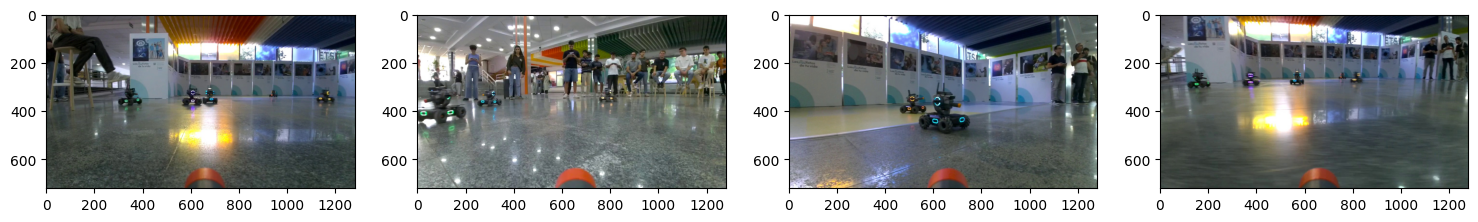

In [5]:
# View Raw frames
show_batch(frames)

## Create data augmentor

### Helper functions

In [6]:
def create_augmentor() -> Compose:
    """Function that creates an augmentor object, which declares the
    transformations that will be applied in the data augmentation process.

    :return:
        augmentor: object defining the transformations to be applied in the
            data augmentation process.
    """
    # List of augmentations available here: https://albumentations.ai/docs/getting_started/transforms_and_targets/ 
    augmentor = alb.Compose(
        [
            alb.HorizontalFlip(p=0.5),
            alb.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=0.2),
            alb.RandomGamma(gamma_limit=(80, 120), eps=None, p=0.2),
            #alb.RandomShadow(shadow_roi=(0.15, 0.15, 0.85, 0.85),num_shadows_lower=1,num_shadows_upper=3,shadow_dimension=4,p=0.25),
            #alb.CoarseDropout(max_holes=8,max_height=32,max_width=32,min_holes=3,min_height=8,min_width=8,fill_value=0,mask_fill_value=None,p=0.3),
            alb.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
            alb.ShiftScaleRotate(shift_limit=0.12, scale_limit=0.1, rotate_limit=7,  p=0.5),
            alb.RandomCrop(height=480, width=640, p=0.5),
            alb.Resize(height=INPUT_SIZE[1], width=INPUT_SIZE[0], p=1.0)
           
            # alb.ImageCompression(quality_lower=99, quality_upper=100, p=0.5),
        ],
        bbox_params=alb.BboxParams(format='pascal_voc', min_area=100, min_visibility=0.3,  label_fields=['class_labels']))
    
    return augmentor

dirty_aug = alb.Compose([
    alb.CoarseDropout(max_holes=16,min_holes=4, max_height=32, max_width=32, p=0.75),
    alb.RandomShadow(shadow_roi=(0.15, 0.15, 0.85, 0.85),num_shadows_lower=1,num_shadows_upper=3,shadow_dimension=4,p=0.25)
])

def load_xml(xml_path: str) -> Tuple[List[List[int]], List[Optional[str]]]:
    """Function that takes in a path to an .xml file, extracts the labels and
    bboxes that it contains, and returns them.

    :param xml_path: path to a single .xml file.
    :return:
        all_bboxes: list that contains all the bboxes contained in the .xml file.
            Each bbox is represented as a list of four values [x_min, y_min, x_max, y_max].
        labels: list containing the labels corresponding to each bbox.
    """
    # Load xml data
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Get all bounding boxes
    all_bboxes = []
    labels = []
    for bboxes in root.iter('object'):
        x_min = int(bboxes.find('bndbox/xmin').text)
        y_min = int(bboxes.find('bndbox/ymin').text)
        x_max = int(bboxes.find('bndbox/xmax').text)
        y_max = int(bboxes.find('bndbox/ymax').text)

        label = bboxes.find('name').text

        bbox = [x_min, y_min, x_max, y_max]
        all_bboxes.append(bbox)
        labels.append(label)
    
    return all_bboxes, labels


def test_augmentor(augmentor: Compose, frame_path: str, xml_path: str) -> None:
    """Function that takes in an augmentor object, a frame path, and a path to
    the corresponding .xml file, and displays the results of applying
    augmentation to a single frame.

    :param augmentor: object defining the transformations to be applied in the
        data augmentation process.
    :param frame_path: path to a single frame.
    :param xml_path: path to a single .xml file.
    :return:
        None
    """
    # Load frame, bboxes, and labels
    frame = cv2.imread(frame_path)
    bboxes, labels = load_xml(xml_path)

    # Augment frame
    augmented = augmentor(image=frame, bboxes=bboxes, class_labels=labels)
    augmented['image'] = dirty_aug(image=augmented['image'])['image']
    # Make a *copy* of the augmented image for drawing to avoid issues
    img_with_bboxes = augmented['image'].copy()
    # Draw augmentation results
    for bbox, label in zip(augmented['bboxes'], augmented['class_labels']):
        # Bounding box is in Pascal VOC format (xmin, ymin, xmax, ymax)
        # and already in absolute pixel values because bbox_params was set.
        x_min, y_min, x_max, y_max = [int(c) for c in bbox]
        # Draw the rectangle
        cv2.rectangle(
            img_with_bboxes,  # Draw on the copy
            (x_min, y_min),   # Top-left corner
            (x_max, y_max),   # Bottom-right corner
            (0, 255, 0),      # Green color (BGR)
            2,                # Thickness
        )
        
        # Optional: Add the label name
        cv2.putText(
            img_with_bboxes,
            str(label),
            (x_min, y_min - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
            cv2.LINE_AA
        )

    # Create a subplot with multiple histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # Added figsize for better view

    # Convert images to RGB and display them
    original_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert the image with drawn bboxes to RGB for matplotlib
    img_to_show = cv2.cvtColor(img_with_bboxes, cv2.COLOR_BGR2RGB)
    
    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original (Size: {frame.shape[1]}x{frame.shape[0]})')
    axes[0].axis('off') # Hide axes ticks/labels

    # Display the augmented image with bounding boxes
    axes[1].imshow(img_to_show)
    axes[1].set_title(f'Augmented (Size: {img_with_bboxes.shape[1]}x{img_with_bboxes.shape[0]})')
    axes[1].axis('off') # Hide axes ticks/labels

    # Adjust the layout
    plt.tight_layout()
    plt.show()

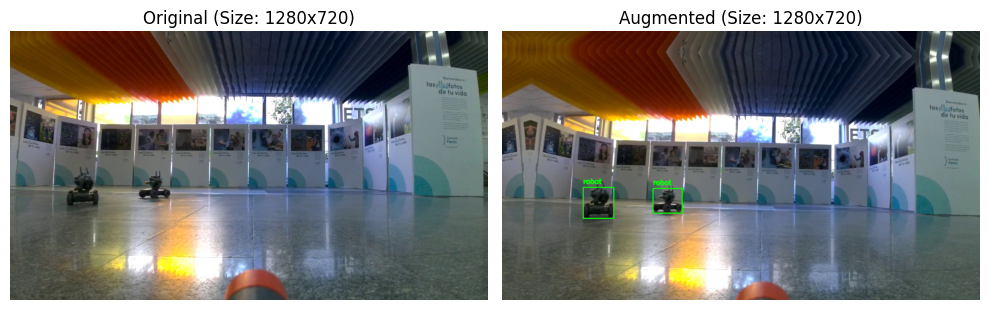

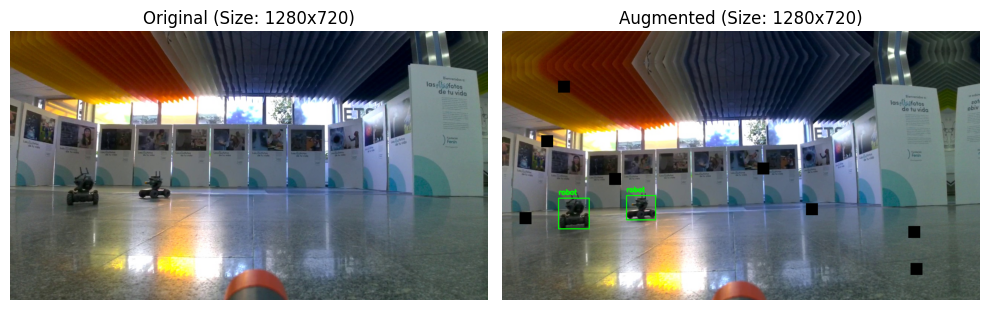

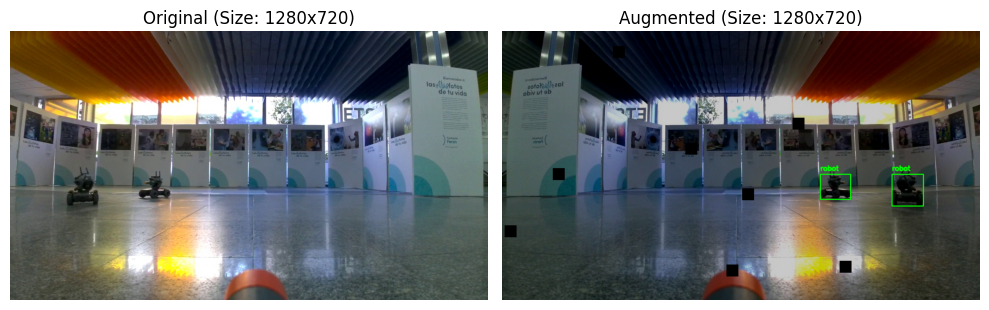

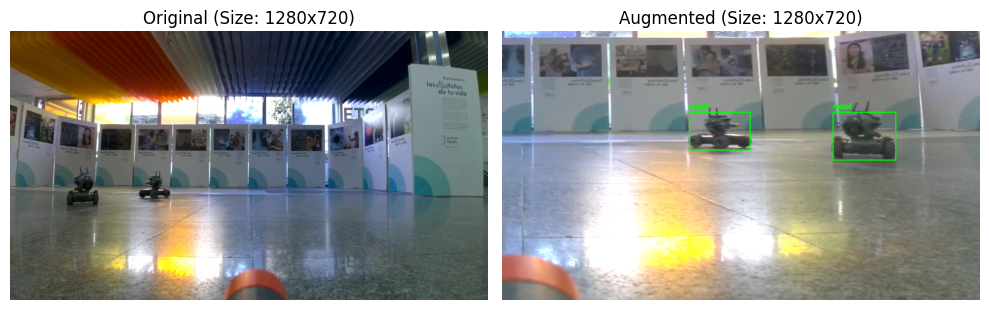

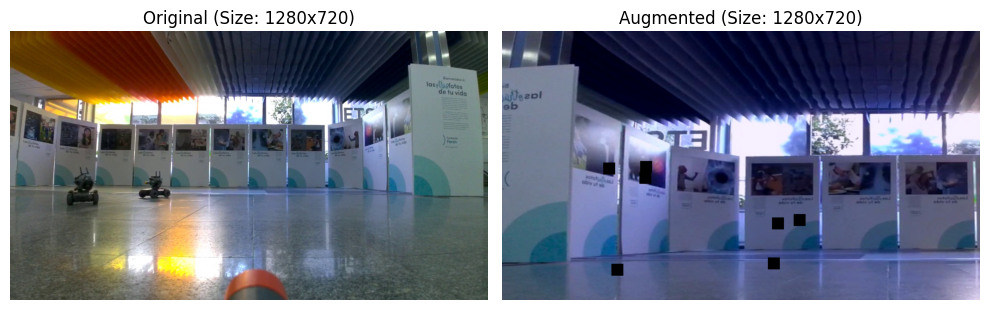

In [7]:
# Create augmentor
augmentor = create_augmentor()

# Test augmentor
for _ in range(5):
    test_augmentor(
        augmentor=augmentor,
        frame_path=os.path.join('../../datasets/hall_266/images', 'frame_0020.jpg'),
        xml_path=os.path.join('../../datasets/hall_266/labels', 'frame_0020.xml'),
    )

## Run data augmentation

### Helper functions

In [12]:
def create_xml(xml_path: str, data: dict) -> None:
    """Function that takes in a .xml path and a dictionary containing data, and
    writes the data into the .xml file.

    :param xml_path: path to the .xml file to write to.
    :param data: dictionary containing the data we want to write.
    :return:
        None
    """
    # Function that adds a newline at the end of each xml tag
    def pretty_print(current, parent=None, index=-1, depth_=0):
        for i, node in enumerate(current):
            pretty_print(node, current, i, depth_ + 1)
        if parent is not None:
            if index == 0:
                parent.text = '\n' + ('\t' * depth_)
            else:
                parent[index - 1].tail = '\n' + ('\t' * depth_)
            if index == len(parent) - 1:
                current.tail = '\n' + ('\t' * (depth_ - 1))

    # Set the xml architecture
    root = ET.Element('annotation')
    folder = ET.SubElement(root, 'folder')
    filename = ET.SubElement(root, 'filename')
    path = ET.SubElement(root, 'path')
    source = ET.SubElement(root, 'source')
    database = ET.SubElement(source, 'database')
    size = ET.SubElement(root, 'size')
    width = ET.SubElement(size, 'width')
    height = ET.SubElement(size, 'height')
    depth = ET.SubElement(size, 'depth')
    segmented = ET.SubElement(root, 'segmented')
    for bbox, label in zip(data['bboxes'], data['labels']):
        object_ = ET.SubElement(root, 'object')
        name = ET.SubElement(object_, 'name')
        pose = ET.SubElement(object_, 'pose')
        truncated = ET.SubElement(object_, 'truncated')
        difficult = ET.SubElement(object_, 'difficult')
        bndbox = ET.SubElement(object_, 'bndbox')
        xmin = ET.SubElement(bndbox, 'xmin')
        ymin = ET.SubElement(bndbox, 'ymin')
        xmax = ET.SubElement(bndbox, 'xmax')
        ymax = ET.SubElement(bndbox, 'ymax')

        # Fill up the data relative to each object
        name.text = str(label)
        pose.text = 'Unspecified'
        truncated.text = '0'
        difficult.text = '0'
        xmin.text = str(int(bbox[0]))
        ymin.text = str(int(bbox[1]))
        xmax.text = str(int(bbox[2]))
        ymax.text = str(int(bbox[3]))

    # Fill up the xml architecture with data
    folder.text = 'images'
    filename.text = f"{xml_path.split(os.sep)[-1].split('.')[0]}.jpg"
    path.text = f"{xml_path.split('.')[0]}.jpg"
    database.text = 'Unknown'
    width.text = '1280'
    height.text = '720'
    depth.text = '3'
    segmented.text = '0'

    # Add new lines after each xml tag
    pretty_print(root)

    # Save the xml file
    tree = ET.ElementTree(root)
    tree.write(xml_path)


def run_data_augmentation(augmentor: Compose, num_augments: int = 10, ignore_aug: bool = True) -> None:
    """Function that defines the data augmentation pipeline to follow. It takes
    in an augmentor object, augments every frame in the dataset, and stores it.

    :param augmentor: object defining the transformations to be applied in the
            data augmentation process.
    :param num_augments: number of augmentations to perform on a frame.
    :param ignore_aug: whether to ignore augmented frames to avoid augmenting augmented data.
    :return:
        None
    """
    for scenario in [x for x in sorted(os.listdir(DATASET_PATH)) if os.path.isdir(os.path.join(DATASET_PATH, x))]:
        
        # Ignore augmented directories
        if ignore_aug and scenario.endswith('-aug'):
            print(f'Skipping:   {scenario}')
            continue
        print(f'Augmenting: {scenario} -> {scenario}-aug')

        # Ignore jupyter checkpoints
        if scenario.startswith('.ipy'):
            continue
        
        # Create augmented directory
        augmented_dir = os.path.join(DATASET_PATH, f'{scenario}-aug')
        if not os.path.exists(augmented_dir):
            os.makedirs(augmented_dir)
            os.makedirs(os.path.join(augmented_dir, 'images'))
            os.makedirs(os.path.join(augmented_dir, 'labels'))

        for frame_name in os.listdir(os.path.join(DATASET_PATH, scenario, 'images')):
            frame_path = os.path.join(DATASET_PATH, scenario, 'images', frame_name)
            label_path = os.path.join(DATASET_PATH, scenario, 'labels', f"{frame_name.split('.')[0]}.xml")

            # Load frame, bboxes, and labels
            frame = cv2.imread(frame_path)

            # If xml file exists, load it
            if os.path.exists(label_path):
                bboxes, labels = load_xml(label_path)

            # Augment the image X times
            for i in range(num_augments):
                augmented = augmentor(image=frame, bboxes=bboxes, class_labels=labels)
                augmented['image'] = dirty_aug(image=augmented['image'])['image']
                cv2.imwrite(
                    os.path.join(augmented_dir, 'images', f"{frame_name.split('.')[0]}_aug_{i:02d}.jpg"),
                    augmented['image']
                )

                # Create a new dictionary to store the values after the augmentation
                annotation = {'image': frame_name}

                # If xml file exists
                if os.path.exists(label_path):
                    annotation['bboxes'] = augmented['bboxes']
                    annotation['labels'] = [1 if label == 'robot' else 0 for label in augmented['class_labels']]

                    create_xml(
                        xml_path=os.path.join(augmented_dir, 'labels', f"{frame_name.split('.')[0]}_aug_{i:02d}.xml"),
                        data=annotation,
                    )

In [13]:
# Run data augmentation pipeline
run_data_augmentation(augmentor=augmentor, num_augments=1)

Augmenting: aire_libre_682 -> aire_libre_682-aug
Skipping:   aire_libre_682-aug
Augmenting: aire_libre_941 -> aire_libre_941-aug
Skipping:   aire_libre_941-aug
Augmenting: hall_116 -> hall_116-aug
Skipping:   hall_116-aug
Augmenting: hall_266 -> hall_266-aug
Skipping:   hall_266-aug
Augmenting: hall_473 -> hall_473-aug
Skipping:   hall_473-aug
Augmenting: pasillo_lab_683 -> pasillo_lab_683-aug
Skipping:   pasillo_lab_683-aug
Augmenting: pasillo_lab_961 -> pasillo_lab_961-aug
Skipping:   pasillo_lab_961-aug
Augmenting: sala_a_150 -> sala_a_150-aug
Skipping:   sala_a_150-aug
Augmenting: sala_b_540 -> sala_b_540-aug
Skipping:   sala_b_540-aug
Augmenting: sala_b_734 -> sala_b_734-aug
Skipping:   sala_b_734-aug
Augmenting: sala_b_775 -> sala_b_775-aug
Skipping:   sala_b_775-aug
Augmenting: sala_c_167 -> sala_c_167-aug
Skipping:   sala_c_167-aug
Augmenting: sala_c_250 -> sala_c_250-aug
Skipping:   sala_c_250-aug
Augmenting: sala_c_352 -> sala_c_352-aug
Skipping:   sala_c_352-aug
Augmenting: 